In [50]:
import matplotlib.pyplot as plt
from ANN_models import PredictionModel, PredictionModel2, PredictionModel3, PredictionModel4, PredictionModel_single_SDS, PredictionModel5
import os 
import json
import torch
import numpy as np
import pandas as pd
import matplotlib as mpl
from tqdm import tqdm
# Default settings
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("seaborn-darkgrid")
plt.rcParams.update({'font.size': 22})

C:\Users\dicky1031\AppData\Local\Temp\ipykernel_7920\2141461968.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-darkgrid")


In [51]:
used_SO2 = 50
result_folder = f"prediction_model_formula24_SO2_{used_SO2}"
subject = "ctchen"


In [52]:
os.makedirs(os.path.join("pic", result_folder, subject), exist_ok=True)
with open(os.path.join("OPs_used", "SO2.json"), 'r') as f:
    SO2 = json.load(f)
    test_SO2 = SO2['test_SO2']
with open(os.path.join("model_save", result_folder, subject, 'trlog.json'), 'r') as f:
    config = json.load(f)
test_loader = torch.load(os.path.join("model_save", result_folder, subject, 'test_loader.pth'))
model = PredictionModel5(neuronsize=5).cuda()
model.load_state_dict(torch.load(config['best_model']))
model.eval()



PredictionModel5(
  (net): Sequential(
    (0): Linear(in_features=800, out_features=640, bias=True)
    (1): ReLU()
    (2): Linear(in_features=640, out_features=320, bias=True)
    (3): ReLU()
    (4): Linear(in_features=320, out_features=160, bias=True)
    (5): ReLU()
    (6): Linear(in_features=160, out_features=80, bias=True)
    (7): ReLU()
    (8): Linear(in_features=80, out_features=40, bias=True)
    (9): ReLU()
    (10): Linear(in_features=40, out_features=1, bias=True)
  )
)

In [53]:
# def cal_R_square(y_true, y_pred):
#     y_bar = np.mean(y_true)
#     numerator = np.sum(np.square(y_true-y_pred))
#     denominator = np.sum(np.square(y_true-y_bar))
#     R_square = 1 - numerator/denominator
    
#     return R_square
# df = {'predic' : [], 'true' : [] , 'error' : [], 'abs_error' : []}
# for i in range(40):
#     df[f'data_value_{i}'] = []
    
# for batch_idx, (data,target, _, _, _) in tqdm(enumerate(test_loader)):
#     data,target = data.to(torch.float32).cuda(), target.to(torch.float32).cuda()
#     output = model(data)
#     output = output.detach().cpu().numpy()
#     target = target.detach().cpu().numpy()
#     for idx in range(output.shape[0]):
#         df['predic'].append(output[idx][0]*100)
#         df['true'].append(target[idx][0]*100)
#         df['error'].append(100*(output[idx][0] - target[idx][0]))
#         df['abs_error'].append(np.abs(100*(output[idx][0] - target[idx][0])))
        
#     for row_idx, one_row in enumerate(data):
#         for idx in range(one_row.shape[0]):
#             df[f'data_value_{idx}'] += [one_row[idx].item()]

# df = pd.DataFrame(df)
# df = df.sort_values('abs_error', ascending=False)
# df.to_csv(os.path.join("pic", result_folder, subject, "RMSE.csv"), index=False)

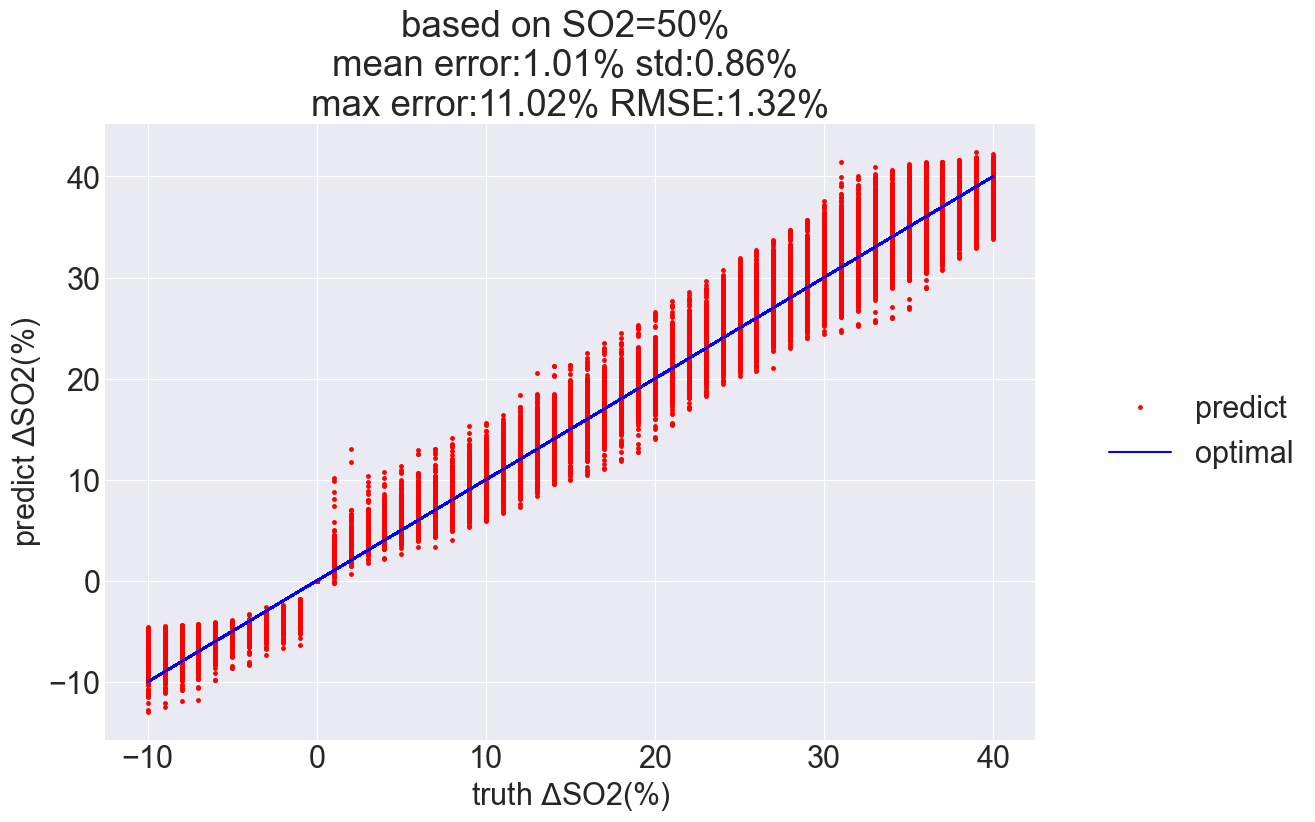

In [54]:
plt.figure(figsize=(12,8))
for batch_idx, (data,target, _,_,_) in enumerate(test_loader):
    data,target = data.to(torch.float32).cuda(), target.to(torch.float32).cuda()
    output = model(data)
    output = output.detach().cpu().numpy()
    target = target.detach().cpu().numpy()
    if batch_idx == 0:
        error = 100*(output - target)
        RMSE = 100*(output - target)
    else:
        error = np.concatenate((error, 100*(output - target)))
        RMSE = np.concatenate((RMSE, 100*(output - target)))
    if batch_idx == 0:
        plt.plot(target*100,output*100, 'r.', markersize=5, label= 'predict')
        plt.plot(target*100,target*100,'b', label = 'optimal')
    else:
        plt.plot(target*100,output*100, 'r.', markersize=5)
        plt.plot(target*100,target*100,'b')

RMSE = np.sqrt(np.mean(np.square(RMSE)))
mean = np.mean(np.abs(error))
std = np.std(np.abs(error))
max_error = np.max(np.abs(error))
plt.title(f"based on SO2={used_SO2}% \nmean error:{mean:.2f}% std:{std:.2f}% \nmax error:{max_error:.2f}% RMSE:{RMSE:.2f}%")
plt.xlabel("truth $\u0394$SO2(%)")
plt.ylabel("predict $\u0394$SO2(%)")
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
          fancybox=True, shadow=True)
plt.savefig(os.path.join("pic", result_folder, subject, "all_metrics.png"), dpi=300, format='png', bbox_inches='tight')
plt.show()

In [55]:
def cal_R_square(y_true, y_pred):
    y_bar = np.mean(y_true)
    numerator = np.sum(np.square(y_true-y_pred))
    denominator = np.sum(np.square(y_true-y_bar))
    R_square = 1 - numerator/denominator
    
    return R_square

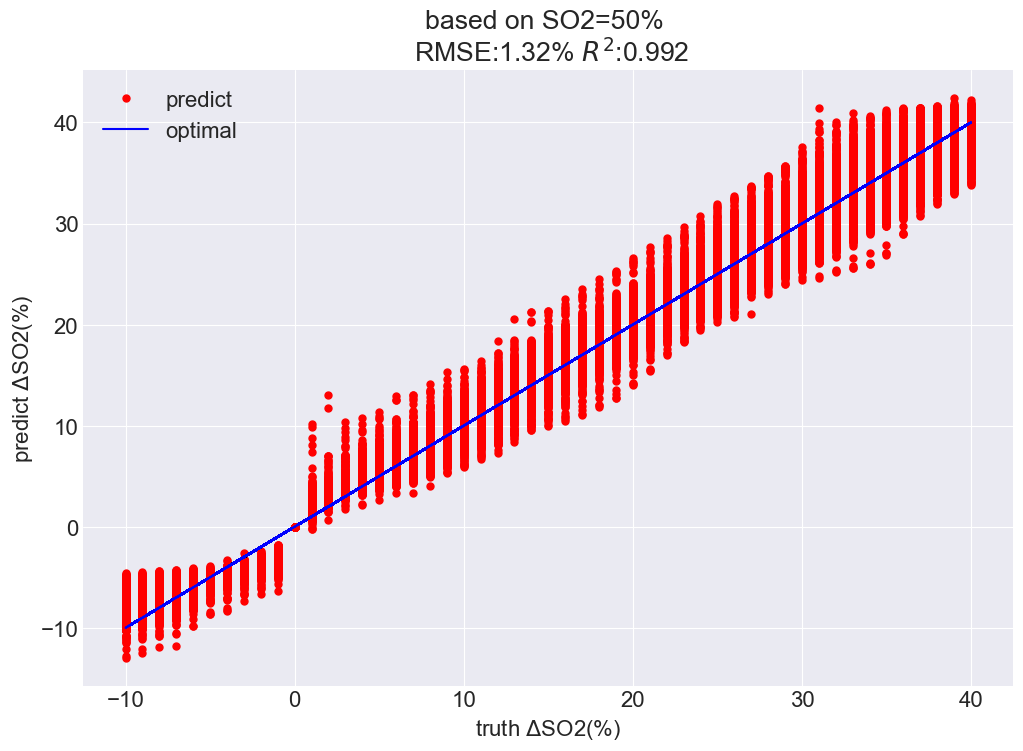

In [56]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(12,8))
for batch_idx, (data,target, _,_,_) in enumerate(test_loader):
    data,target = data.to(torch.float32).cuda(), target.to(torch.float32).cuda()
    output = model(data)
    output = output.detach().cpu().numpy()
    target = target.detach().cpu().numpy()
    if batch_idx == 0:
        error = 100*(output - target)
        accumulate_RMSE = 100*(output - target)
        accumulate_output = output
        accumulate_target = target
    else:
        error = np.concatenate((error, 100*(output - target)))
        accumulate_RMSE = np.concatenate((accumulate_RMSE, 100*(output - target)))
        accumulate_output = np.concatenate((accumulate_output, output))
        accumulate_target = np.concatenate((accumulate_target, target))
    if batch_idx == 0:
        plt.plot(target*100,output*100, 'r.', markersize=10, label= 'predict')
        plt.plot(target*100,target*100,'b', label = 'optimal')
    else:
        plt.plot(target*100,output*100, 'r.', markersize=10)
        plt.plot(target*100,target*100,'b')

RMSE = np.sqrt(np.mean(np.square(accumulate_RMSE)))
R_square = cal_R_square(y_true=accumulate_target, y_pred=accumulate_output)
plt.title(f"based on SO2={used_SO2}% \n RMSE:{RMSE:.2f}% $R^{2}$:{R_square:.3f}")
plt.xlabel("truth $\u0394$SO2(%)")
plt.ylabel("predict $\u0394$SO2(%)")
plt.legend()
plt.savefig(os.path.join("pic", result_folder, subject, "RMSE.png"), dpi=300, format='png', bbox_inches='tight')
# plt.close()
plt.show()

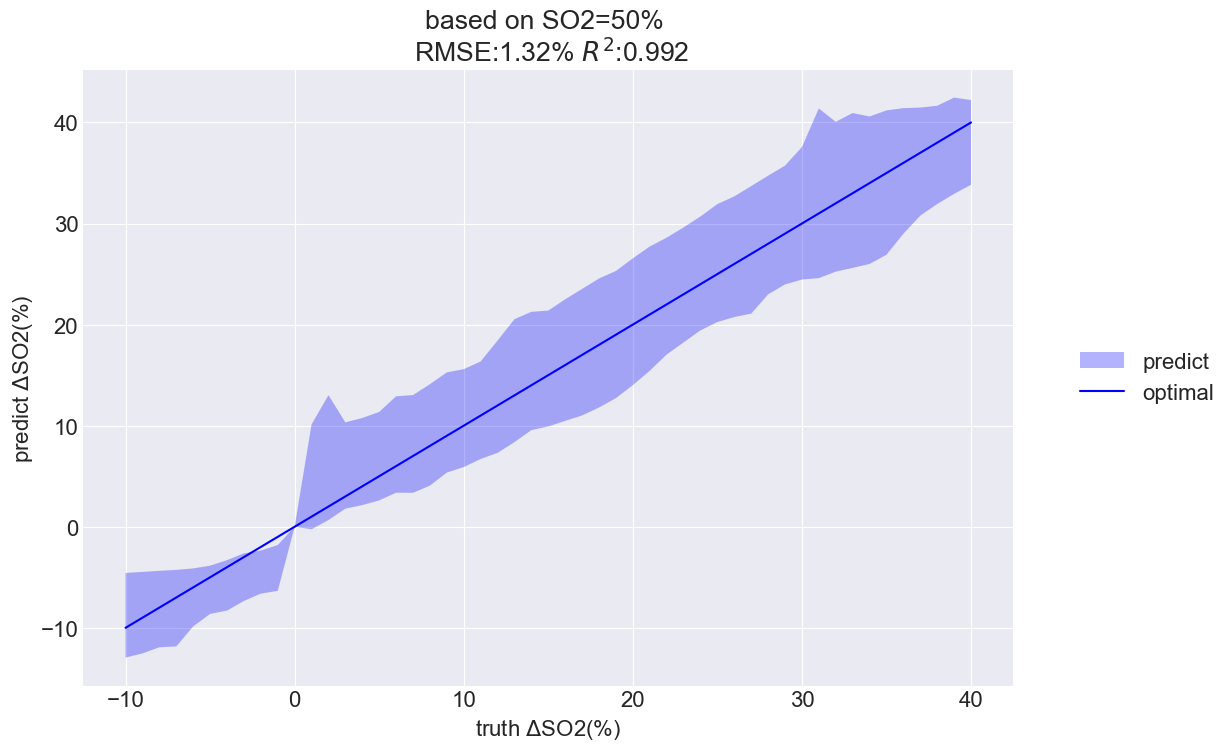

In [57]:
table = {}
for using_SO2 in test_SO2:
    table[using_SO2] = []
for i in range(accumulate_target.shape[0]):
    key = np.around(accumulate_target[i][0] + used_SO2*0.01,2)
    table[key] += [accumulate_output[i][0]-accumulate_target[i][0]]

accumulate_std1 = []
accumulate_std2 = []
accumulate_x = []
for key in table.keys():
    data = np.array(table[key])
    std1 = max(data)
    std2 = min(data)
    # std1 = np.std(data[np.where(data>=0)])
    # std2 = np.std(data[np.where(data<=0)])
    if np.isnan(std1):
        std1 = 0
    if np.isnan(std2):
        std2 = 0
    ijv_change = np.around(key - used_SO2*0.01, 2)
    accumulate_std1.append(std1)
    accumulate_std2.append(std2)
    accumulate_x.append(ijv_change)
accumulate_std1 = np.array(accumulate_std1)*100
accumulate_std2 = np.array(accumulate_std2)*100
accumulate_x = np.array(accumulate_x)*100
plt.figure(figsize=(12,8))
plt.fill_between(accumulate_x, accumulate_x+accumulate_std1, accumulate_x+accumulate_std2, color='b', alpha=0.3, edgecolor=None, label='predict')
plt.plot(accumulate_x,accumulate_x, 'b', label='optimal')
plt.title(f"based on SO2={used_SO2}% \n RMSE:{RMSE:.2f}% $R^{2}$:{R_square:.3f}")
plt.xlabel("truth $\u0394$SO2(%)")
plt.ylabel("predict $\u0394$SO2(%)")
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
          fancybox=True, shadow=True)
plt.savefig(os.path.join("pic", result_folder, subject, "RMSE_fill_plot.png"), dpi=300, format='png', bbox_inches='tight')
plt.show()

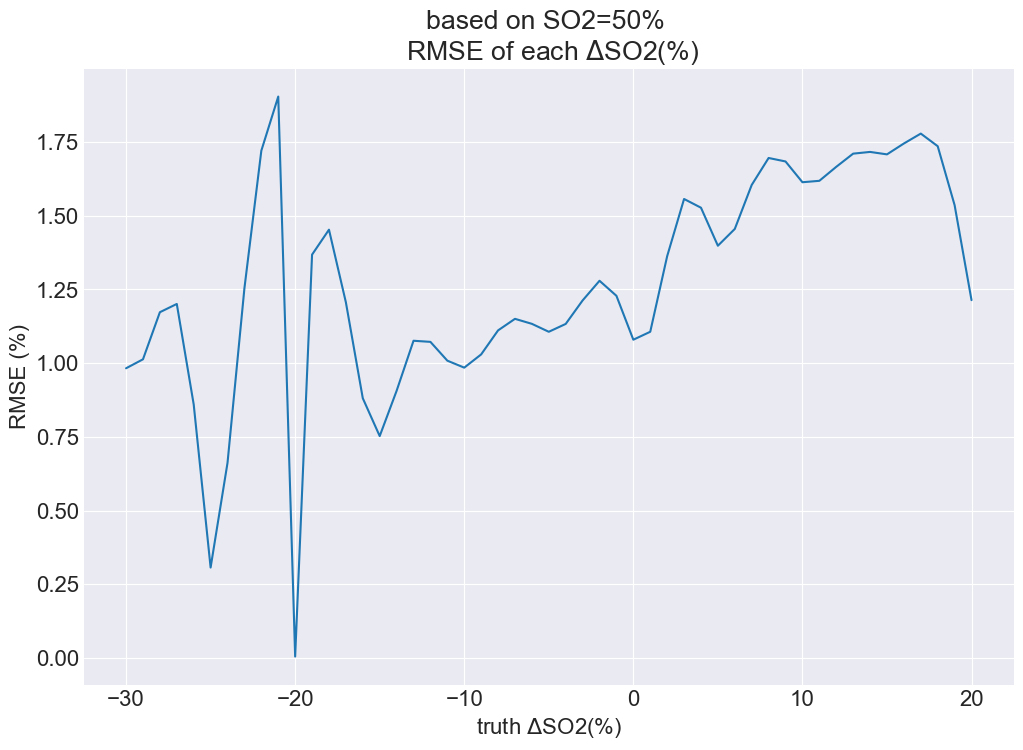

In [58]:
accumulate_x = []
for key in table.keys():
    data = np.array(table[key])
    RMSE = np.sqrt(np.mean(np.square(data*100)))
    accumulate_x.append(RMSE)
plt.figure(figsize=(12,8))
plt.plot((np.array(test_SO2)-0.7)*100, accumulate_x)
plt.title(f"based on SO2={used_SO2}% \n RMSE of each $\u0394$SO2(%)")
plt.xlabel("truth $\u0394$SO2(%)")
plt.ylabel("RMSE (%)")
plt.savefig(os.path.join("pic", result_folder, subject, "RMSE_each_plot.png"), dpi=300, format='png', bbox_inches='tight')
plt.show()

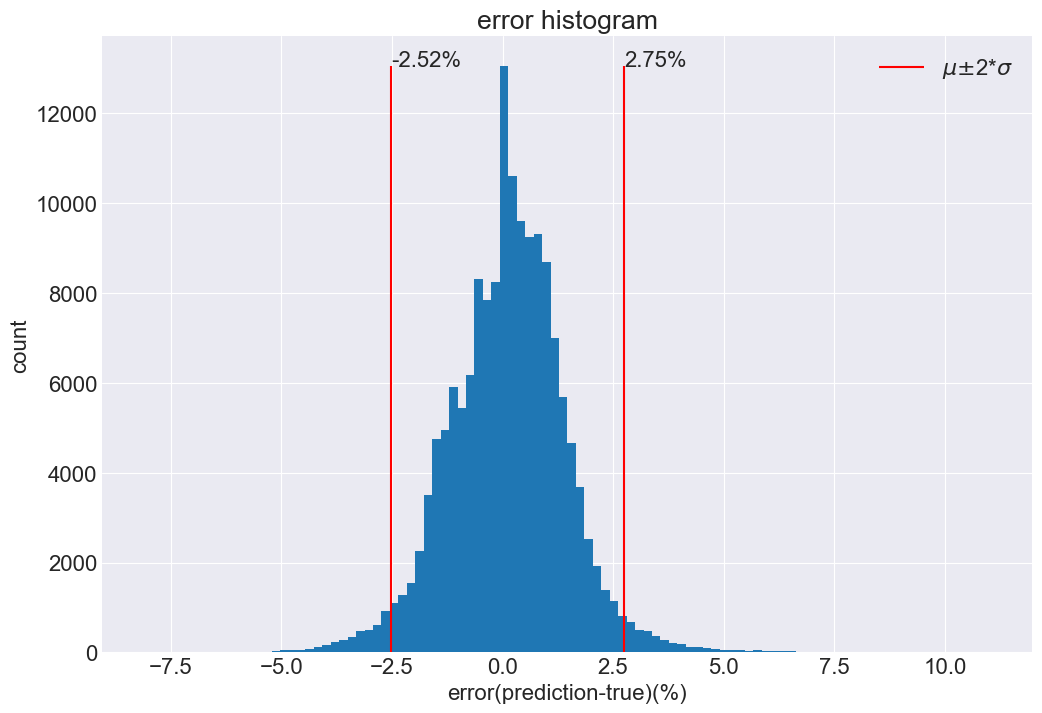

In [59]:
mean = np.mean(error)
std = np.std(error)
plt.figure(figsize=(12,8))
n,bin, pack = plt.hist(error, bins=100)
plt.vlines([mean+2*std, mean-2*std], 0, max(n), 'r', label='$\mu$$\pm$2*$\sigma$')
plt.text(mean+2*std, max(n), f'{mean+2*std:.2f}%')
plt.text(mean-2*std, max(n), f'{mean-2*std:.2f}%')
plt.xlabel('error(prediction-true)(%)')
plt.ylabel('count')
plt.title('error histogram')
plt.legend()
plt.savefig(os.path.join("pic", result_folder, subject, "hist.png"), dpi=300, format='png', bbox_inches='tight')
plt.show()


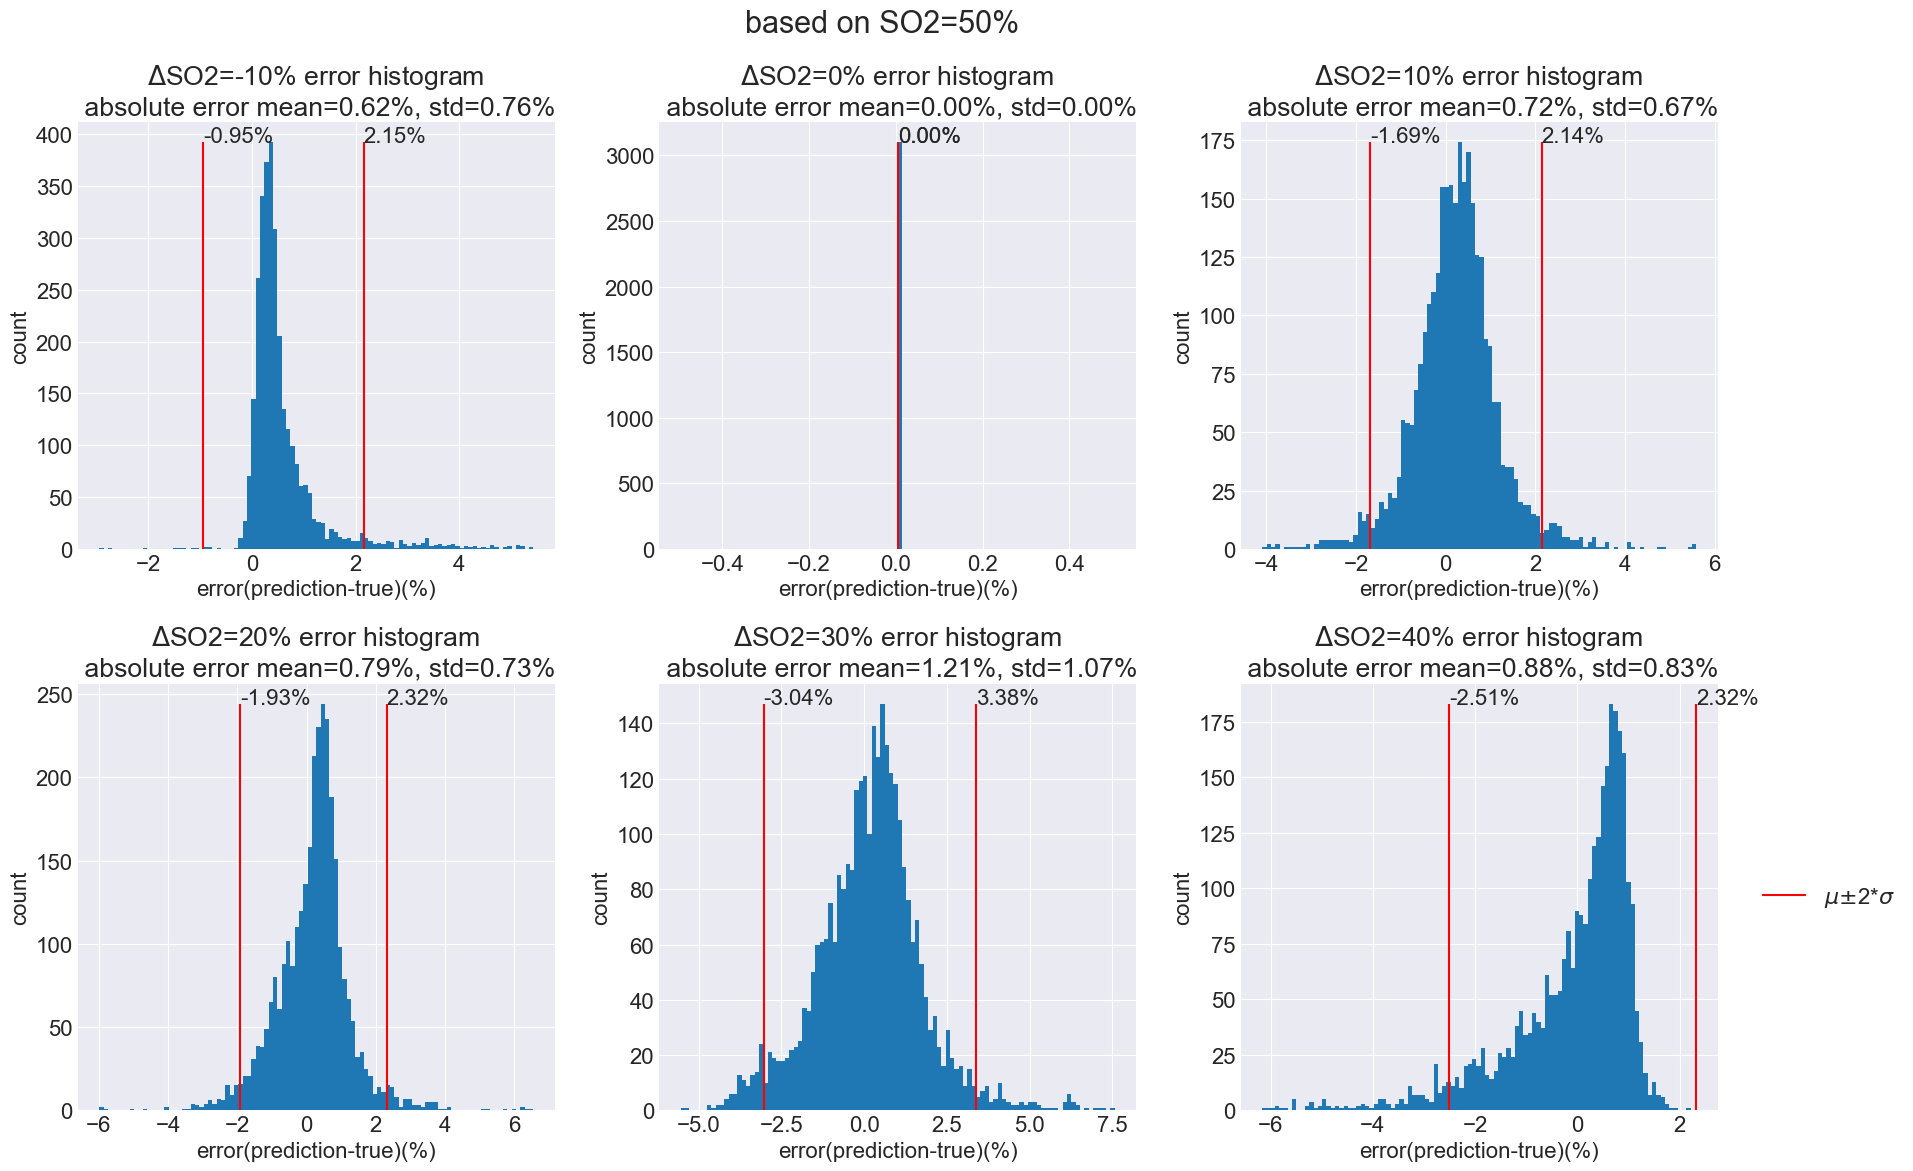

In [60]:
plt.rcParams.update({'font.size': 16})
fig = plt.figure(figsize=(18,12))
fig.suptitle(f"based on SO2={used_SO2}% ", fontsize=22)

count = 1
for key in table.keys():
    data = np.array(table[key])
    if key*100==used_SO2:
        specific_error = data*100   
        specific_error = np.sort(specific_error)[1:-1] 
    else:
        specific_error = data*100    
    mean = np.mean(specific_error)
    std = np.std(specific_error)
    
    abs_mean = np.mean(np.abs(specific_error))
    abs_std = np.std(np.abs(specific_error))
    
    if key*100%10 == 0:
        ## plot result
        ax = plt.subplot(2,3, count)
        ax.set_title(f'$\u0394$SO2={int(key*100)-used_SO2}% error histogram \n absolute error mean={abs_mean:.2f}%, std={abs_std:.2f}%')
        n,bin, pack = ax.hist(specific_error, bins=100)
        ax.set_xlabel('error(prediction-true)(%)')
        ax.set_ylabel('count')
        ax.vlines([mean+2*std, mean-2*std], 0, max(n), 'r', label='$\mu$$\pm$2*$\sigma$')
        ax.text(mean+2*std, max(n), f'{mean+2*std:.2f}%')
        ax.text(mean-2*std, max(n), f'{mean-2*std:.2f}%')
        count += 1
    
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
                    fancybox=True, shadow=True)
plt.savefig(os.path.join("pic", result_folder, subject, f"each_SO2_hist.png"), dpi=300, format='png', bbox_inches='tight')
plt.show()

In [61]:
# plt.rcParams.update({'font.size': 18})
# used_SO2_set = [50, 60, 70]
# fig = plt.figure(figsize=(16,9))
# # fig.suptitle(f"based on SO2={used_SO2}% ", fontsize=16)
# count = 1
# for used_SO2 in used_SO2_set:
#     ax = plt.subplot(1,3, count)
#     count += 1
#     result_folder = f"prediction_model_formula24_SO2_{used_SO2}"
#     subject = "ctchen"
#     os.makedirs(os.path.join("pic", result_folder, subject), exist_ok=True)
#     with open(os.path.join("OPs_used", "SO2.json"), 'r') as f:
#         SO2 = json.load(f)
#         test_SO2 = SO2['test_SO2']
#     with open(os.path.join("model_save", result_folder, subject, 'trlog.json'), 'r') as f:
#         config = json.load(f)
#     test_loader = torch.load(os.path.join("model_save", result_folder, subject, 'test_loader.pth'))
#     model = PredictionModel5(neuronsize=5).cuda()
#     model.load_state_dict(torch.load(config['best_model']))
#     model.eval()

 
#     for batch_idx, (data,target, _,_,_) in enumerate(test_loader):
#         data,target = data.to(torch.float32).cuda(), target.to(torch.float32).cuda()
#         output = model(data)
#         output = output.detach().cpu().numpy()
#         target = target.detach().cpu().numpy()
#         if batch_idx == 0:
#             error = 100*(output - target)
#             accumulate_RMSE = 100*(output - target)
#             accumulate_output = output
#             accumulate_target = target
#         else:
#             error = np.concatenate((error, 100*(output - target)))
#             accumulate_RMSE = np.concatenate((accumulate_RMSE, 100*(output - target)))
#             accumulate_output = np.concatenate((accumulate_output, output))
#             accumulate_target = np.concatenate((accumulate_target, target))
#         if batch_idx == 0:
#             ax.plot(target*100,output*100, 'r.', markersize=5, label= 'predict')
#             ax.plot(target*100,target*100,'b', label = 'optimal')
#         else:
#             ax.plot(target*100,output*100, 'r.', markersize=5)
#             ax.plot(target*100,target*100,'b')

#     RMSE = np.sqrt(np.mean(np.square(accumulate_RMSE)))
#     R_square = cal_R_square(y_true=accumulate_target, y_pred=accumulate_output)
#     ax.set_title(f"based on SO2={used_SO2}% \n RMSE:{RMSE:.2f}% $R^{2}$:{R_square:.3f}")
#     ax.set_xlabel("truth $\u0394$SO2(%)")
#     ax.set_ylabel("predict $\u0394$SO2(%)")

# plt.tight_layout()
# plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
#                     fancybox=True, shadow=True)
# plt.savefig(os.path.join("pic", result_folder, subject, "RMSE_set.png"), dpi=300, format='png', bbox_inches='tight')
# plt.show()